<a href="https://colab.research.google.com/github/tr41z/machine-learning/blob/main/art_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import tensorflow as tf
from google.colab import drive
import os
from PIL import Image
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from IPython.display import clear_output
import numpy as np
import time

In [49]:
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/Colab Notebooks/Datasets/GANs/art.zip' -d './art'

Streaming output truncated to the last 5000 lines.
  inflating: ./art/art/resized/Paul_Gauguin_142.jpg  
  inflating: ./art/__MACOSX/art/resized/._Paul_Gauguin_142.jpg  
  inflating: ./art/art/resized/Vincent_van_Gogh_279.jpg  
  inflating: ./art/__MACOSX/art/resized/._Vincent_van_Gogh_279.jpg  
  inflating: ./art/art/resized/Paul_Gauguin_156.jpg  
  inflating: ./art/__MACOSX/art/resized/._Paul_Gauguin_156.jpg  
  inflating: ./art/art/resized/Sandro_Botticelli_1.jpg  
  inflating: ./art/__MACOSX/art/resized/._Sandro_Botticelli_1.jpg  
  inflating: ./art/art/resized/Henri_Rousseau_50.jpg  
  inflating: ./art/__MACOSX/art/resized/._Henri_Rousseau_50.jpg  
  inflating: ./art/art/resized/Eugene_Delacroix_28.jpg  
  inflating: ./art/__MACOSX/art/resized/._Eugene_Delacroix_28.jpg  
  inflating: ./art/art/resized/Pierre-Auguste_Renoir_31.jpg  
  inflating: ./art/__MACOSX/art/resized/._Pierre-Auguste_Renoir_31.jpg  
  inflating: ./art/art/resized/Gustav_Klimt_63.jpg  
  inflating: ./art/__MACO

In [82]:
BATCH_SIZE = 64
LATENT_DIM = 512
IMAGE_SIZE = 128

In [83]:
def rescale_images(path):
    for image_name in os.listdir(path):
        # Create full path to the image file
        image_path = os.path.join(path, image_name)

        # Read the image
        img = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if img is not None:
            # Resize the image
            resized_img = cv2.resize(img, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)

            # Save the resized image back to the same path, overwriting the original
            cv2.imwrite(image_path, resized_img)
        else:
            print(f"Failed to load image: {image_name}")

In [84]:
def inspect_images(path):
    for image_name in os.listdir(path):
        # Create full path to the image file
        image_path = os.path.join(path, image_name)

        # Read the image
        img = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if img is not None:
            height, width, channels = img.shape
            print(f"Image: {image_name} - Height: {height}, Width: {width}, Channels: {channels}")
        else:
            print(f"Failed to load image: {image_name}")

    return None

In [85]:
path = '/content/art/art/resized'
dataset = rescale_images(path)  # Get the dataset of resized images
inspect_images(path)  # Pass the dataset to inspect_images

Streaming output truncated to the last 5000 lines.
Image: Edgar_Degas_33.jpg - Height: 128, Width: 128, Channels: 3
Image: Henri_Matisse_74.jpg - Height: 128, Width: 128, Channels: 3
Image: Amedeo_Modigliani_48.jpg - Height: 128, Width: 128, Channels: 3
Image: Edgar_Degas_619.jpg - Height: 128, Width: 128, Channels: 3
Image: Pieter_Bruegel_36.jpg - Height: 128, Width: 128, Channels: 3
Image: Kazimir_Malevich_9.jpg - Height: 128, Width: 128, Channels: 3
Image: Francisco_Goya_110.jpg - Height: 128, Width: 128, Channels: 3
Image: Pablo_Picasso_421.jpg - Height: 128, Width: 128, Channels: 3
Image: Albrecht_Du╠êrer_234.jpg - Height: 128, Width: 128, Channels: 3
Image: Paul_Gauguin_87.jpg - Height: 128, Width: 128, Channels: 3
Image: Andy_Warhol_103.jpg - Height: 128, Width: 128, Channels: 3
Image: Pierre-Auguste_Renoir_4.jpg - Height: 128, Width: 128, Channels: 3
Image: Albrecht_Dürer_130.jpg - Height: 128, Width: 128, Channels: 3
Image: Edgar_Degas_181.jpg - Height: 128, Width: 128, Chan

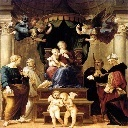

In [86]:
img = cv2.imread(f'{path}/Raphael_65.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [87]:
class Generator(tf.keras.Model):
  def __init__(self) -> None:
    super(Generator, self).__init__()

    self.dense = tf.keras.layers.Dense(7 * 7 * 256, use_bias=False)
    self.batch_normalization_1 = tf.keras.layers.BatchNormalization()
    self.leakyRelu_1 = tf.keras.layers.LeakyReLU()
    self.reshape = tf.keras.layers.Reshape((7, 7, 256))
    self.conv2dTranspose_1 = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
    self.batch_normalization_2 = tf.keras.layers.BatchNormalization()
    self.leakyRelu_2 = tf.keras.layers.LeakyReLU()
    self.conv2dTranspose_2 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
    self.batch_normalization_3 = tf.keras.layers.BatchNormalization()
    self.leakyRelu_3 = tf.keras.layers.LeakyReLU()
    self.conv2dTranspose_3 = tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')

  def call(self, inputs):
    x = self.dense(inputs)
    x = self.batch_normalization_1(x)
    x = self.leakyRelu_1(x)
    x = self.reshape(x)
    x = self.conv2dTranspose_1(x)
    x = self.batch_normalization_2(x)
    x = self.leakyRelu_2(x)
    x = self.conv2dTranspose_2(x)
    x = self.batch_normalization_3(x)
    x = self.leakyRelu_3(x)
    return self.conv2dTranspose_3(x)

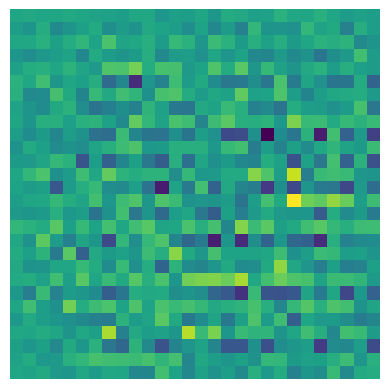

In [88]:
generator = Generator()

# Generate random noise (latent vector)
noise = tf.random.normal([1, LATENT_DIM])  # Batch size of 1, latent_dim of 512

# Generate an image using the Generator
generated_image = generator(noise, training=False)

# Rescale the image from [-1, 1] to [0, 255]
rescaled_image = (generated_image[0, :, :, 0] + 1) * 127.5

# Display the image
plt.imshow(rescaled_image.numpy())  # Convert tensor to NumPy
plt.axis('off')
plt.show()

In [45]:
class Discriminator(tf.keras.Model):
  def __init__(self) -> None:
      super(Discriminator, self).__init__()

      self.conv2d_1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
      self.leakyRelu_1 = tf.keras.layers.LeakyReLU()
      self.dropout_1 = tf.keras.layers.Dropout(0.3)
      self.conv2d_2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
      self.leakyRelu_2 = tf.keras.layers.LeakyReLU()
      self.dropout_2 = tf.keras.layers.Dropout(0.3)
      self.flatten = tf.keras.layers.Flatten()
      self.dense = tf.keras.layers.Dense(1)  # Output layer

  def call(self, inputs):
    x = self.conv2d_1(inputs)
    x = self.leakyRelu_1(x)
    x = self.dropout_1(x)
    x = self.conv2d_2(x)
    x = self.leakyRelu_2(x)
    x = self.dropout_2(x)
    x = self.flatten(x)
    return self.dense(x)

In [46]:
discriminator = Discriminator()

# Make prediction on generated image
pred = discriminator.call(generated_image)
print(pred)

tf.Tensor([[0.00104552]], shape=(1, 1), dtype=float32)


In [47]:
class GAN(tf.keras.Model):
  def __init__(self) -> None:
    super(GAN, self).__init__()

  def compile(self, disc_opt, gen_opt, disc_loss, gen_loss):
    pass